In [1]:
import scanpy as sc
import anndata
import scenvi

import numpy as np
import umap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

CUDA backend failed to initialize: Unable to load cuDNN. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/chananchidas/miniconda3/envs/scenvi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# !wget https://dp-lab-data-public.s3.amazonaws.com/ENVI/sc_data.h5ad
#!wget https://dp-lab-data-public.s3.amazonaws.com/ENVI/st_data.h5ad


In [2]:
# Open resolve data
slide = "A1-1"
st_data = anndata.read_zarr("sdata" + slide + "_optimized/sdata.zarr/table/table")

# Sample data
# st_data = sc.read_h5ad("st_data.h5ad")

In [6]:
# Save as csv
#st_data.obs.to_csv("st_data.csv")
#st_data.var.to_csv("st_data_genes.csv")

# Save counts as csv
st_data.write_csvs("resolveA1-1", skip_data=False)


In [ ]:
# Vizgen data
st_data.X # normalized and scaled
st_data.raw.X # only normalized (by the size of the cell)

In [5]:
# Replace scaled data with normalized data (otherwise COVET doesn't work)
st_data.X = st_data.raw.X.copy()

In [ ]:
# st_data.raw = anndata.AnnData(X=st_data.layers["raw_counts"].copy(), obs=st_data.obs, var=st_data.var)
# st_data.write_h5ad("vizgen_data.h5ad")

In [4]:
# Run COVET
st_data.obsm['COVET'], st_data.obsm['COVET_SQRT'], st_data.uns['CovGenes'] = scenvi.compute_covet(st_data)

In [5]:
print(st_data.obsm['COVET_SQRT'].shape)

# Flatten the data to 2D
covet_sqrt = np.reshape(st_data.obsm['COVET_SQRT'], (st_data.obsm['COVET_SQRT'].shape[0], -1))

# Save covet_sqrt
np.save("covet_sqrt_resolve" + slide + ".npy", covet_sqrt)

(11283, 64, 64)


In [ ]:
# # Try running different UMAP parameters for the COVET values - but do this on the HPC

# # Store embeddings in empty dictionary
# embeddings = {}

# # Try min_dist = 0, 0.1, 0.25, 0.5, 0.8, 0.99
# # Try n_neighbors = 2, 5, 10, 20, 50, 100
# # Try metric: euclidean, cosine
# min_dist_list = [0, 0.1, 0.25, 0.5, 0.8, 0.99]
# n_neighbors_list = [2, 5, 10, 20, 50, 100]
# metric_list = ['euclidean', 'cosine']

# for metric in metric_list:
#     for min_dist in min_dist_list:
#         for n_neighbors in n_neighbors_list:
#             reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric,
#                                 random_state=0)
#             embedding = reducer.fit_transform(covet_sqrt)
#             embeddings[f"neighbors_{n_neighbors}_mindist_{min_dist}_metric_{metric}"] = embedding


# # Save embeddings
# with open(path + 'embeddings.p', 'wb') as fp:
#     pickle.dump(embeddings, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# Load pickled embeddings
with open('embeddings_resolve' + slide + '.p', 'rb') as fp:
    embeddings = pickle.load(fp)

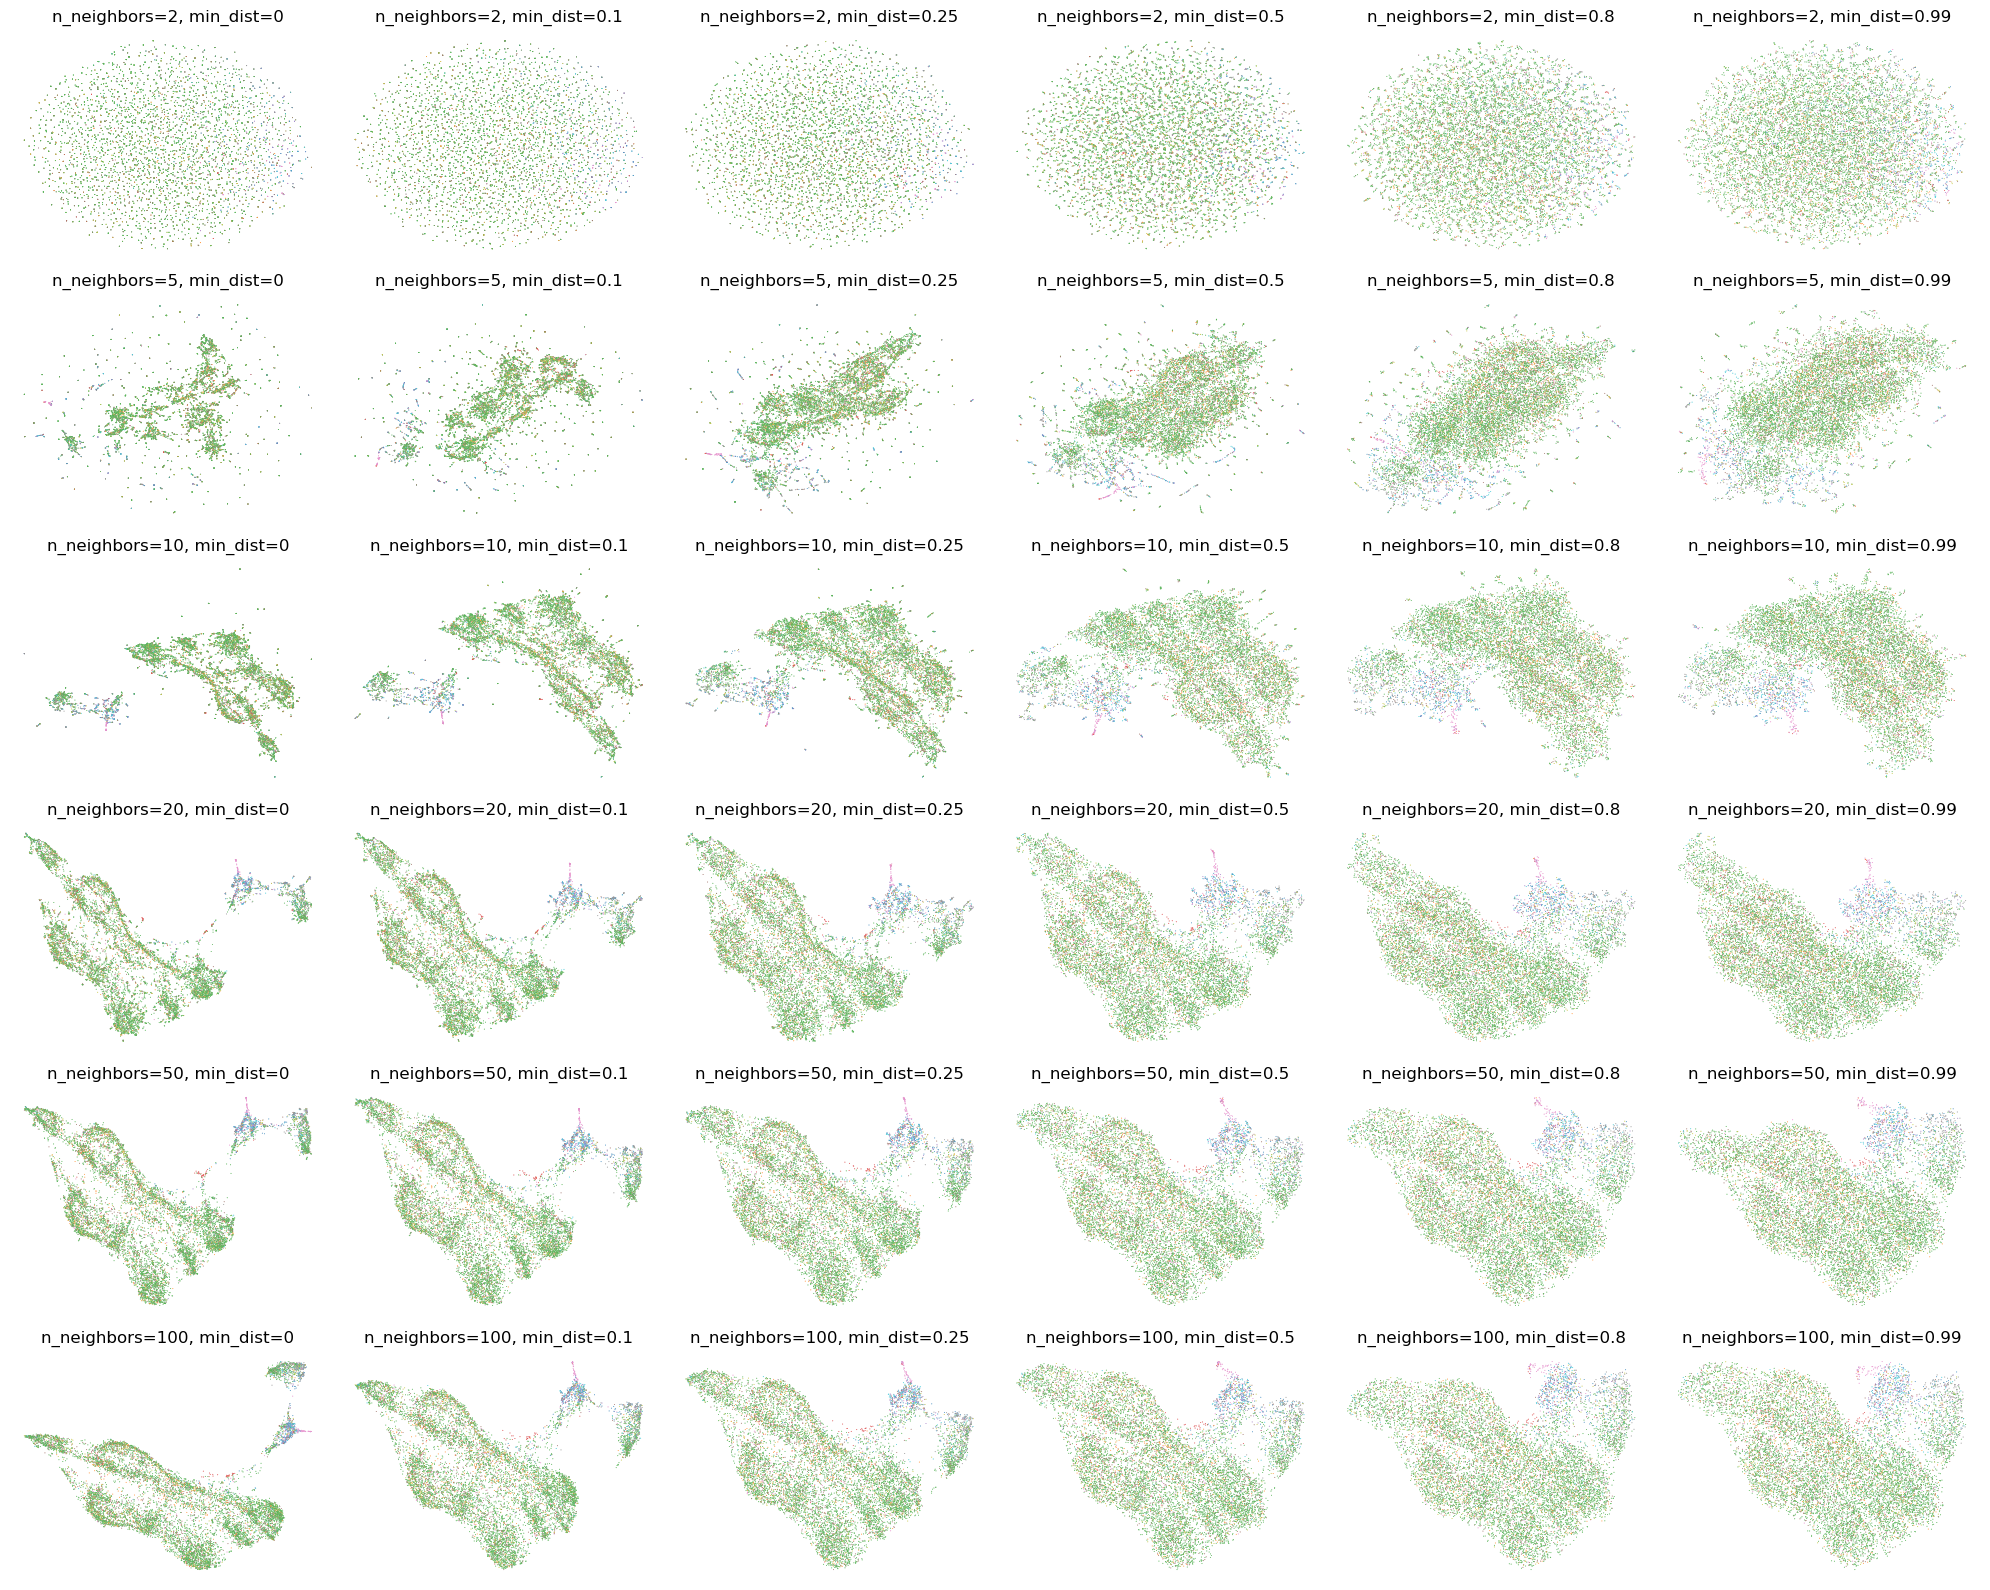

In [7]:
# Plot the embeddings
min_dist_list = [0, 0.1, 0.25, 0.5, 0.8, 0.99]
n_neighbors_list = [2, 5, 10, 20, 50, 100]

fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(20, 16))

for i in range(len(n_neighbors_list)):
    for j in range(len(min_dist_list)):
        
        embedding = embeddings[f"neighbors_{n_neighbors_list[i]}_mindist_{min_dist_list[j]}_metric_euclidean"]
        
    
        # Create pandas dataframe combining embedding and cell type annotation
        df = pd.DataFrame(embedding, columns=['X', 'Y'])

        # Append cell type annotation to the dataframe
        df['celltype'] = st_data.obs['annotation_own_score_genes'].reset_index(drop=True)
        
        sns.scatterplot(data=df, x='X', y='Y', hue='celltype', ax=axes[i, j], s=0.5)
        
        # Turn off legend
        axes[i, j].get_legend().remove()
        axes[i, j].axis('off')
        axes[i, j].set_title(f"n_neighbors={n_neighbors_list[i]}, min_dist={min_dist_list[j]}")
    
plt.tight_layout()
plt.show()


In [ ]:
# Plot the cosine embeddings
min_dist_list = [0, 0.1, 0.25, 0.5, 0.8, 0.99]
n_neighbors_list = [2, 5, 10, 20, 50, 100]

fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(20, 16))

for i in range(len(n_neighbors_list)):
    for j in range(len(min_dist_list)):
        
        embedding = embeddings[f"neighbors_{n_neighbors_list[i]}_mindist_{min_dist_list[j]}_metric_cosine"]
        
    
        # Create pandas dataframe combining embedding and cell type annotation
        df = pd.DataFrame(embedding, columns=['X', 'Y'])

        # Append cell type annotation to the dataframe
        df['celltype'] = st_data.obs['annotation_own_score_genes'].reset_index(drop=True)
        
        sns.scatterplot(data=df, x='X', y='Y', hue='celltype', ax=axes[i, j], s=0.5)
        
        axes[i, j].get_legend().remove()
        axes[i, j].axis('off')
        axes[i, j].set_title(f"n_neighbors={n_neighbors_list[i]}, min_dist={min_dist_list[j]}")
    
plt.tight_layout()
plt.show()


In [8]:
# Get the best UMAP embeddings
st_data.obsm['covet_umap'] = embeddings[f"neighbors_20_mindist_0.5_metric_euclidean"]
st_data.obsm['covet_sqrt_flat'] = covet_sqrt

# Leiden

In [9]:
sc.pp.neighbors(st_data, n_neighbors=20,
                use_rep='covet_sqrt_flat',
                method='umap', metric='euclidean',
                n_pcs=st_data.obsm["covet_sqrt_flat"].shape[1],
                key_added='neighbors_covet')

In [10]:
sc.tl.leiden(
    st_data,
    resolution=0.5,
    key_added='leiden_covet',
    neighbors_key='neighbors_covet',
    flavor="igraph"
)

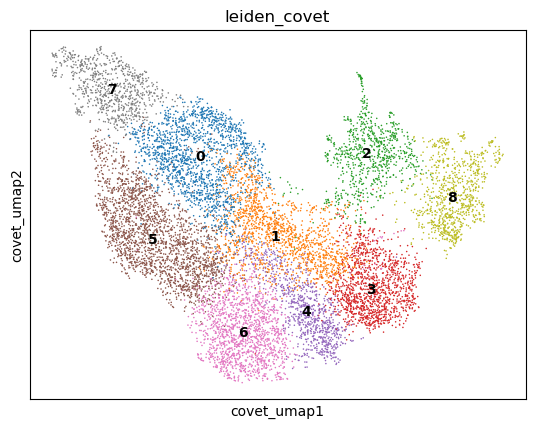

In [12]:
sc.pl.embedding(st_data, basis='covet_umap', color='leiden_covet',
                legend_loc='on data', s=5)

<Axes: title={'center': 'leiden'}, xlabel='spatial1', ylabel='spatial2'>

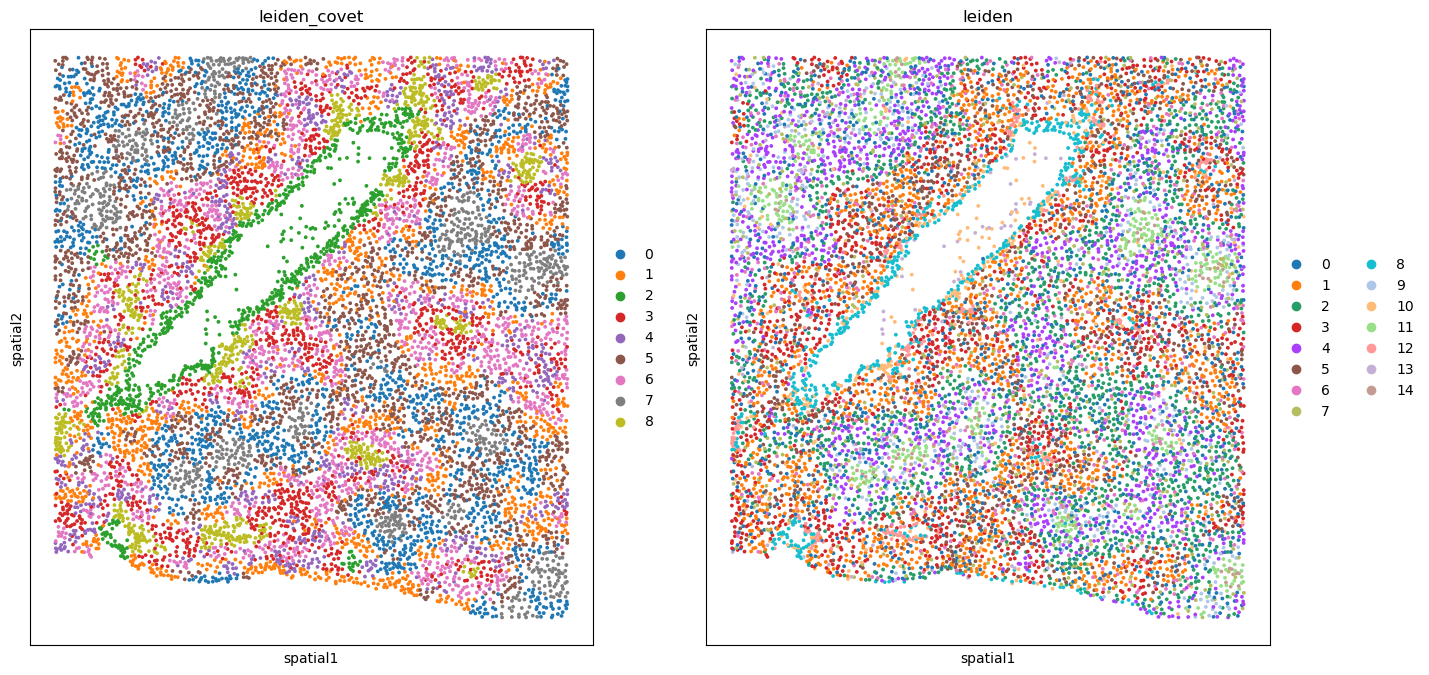

In [15]:
# Plot UMAP of COVET embeddings vs normal UMAP
# Create subplot of two columns
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Covet UMAP
sc.pl.embedding(st_data, basis='spatial', color='leiden_covet', size=30, ax=axes[0], show=False)

# Plot normal UMAP
sc.pl.embedding(st_data, basis='spatial', color='leiden', size=30, ax=axes[1], show=False)

/tmp/ipykernel_11544/620034336.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = st_data.obs.groupby(['leiden_covet', 'annotationSave']).size().unstack()


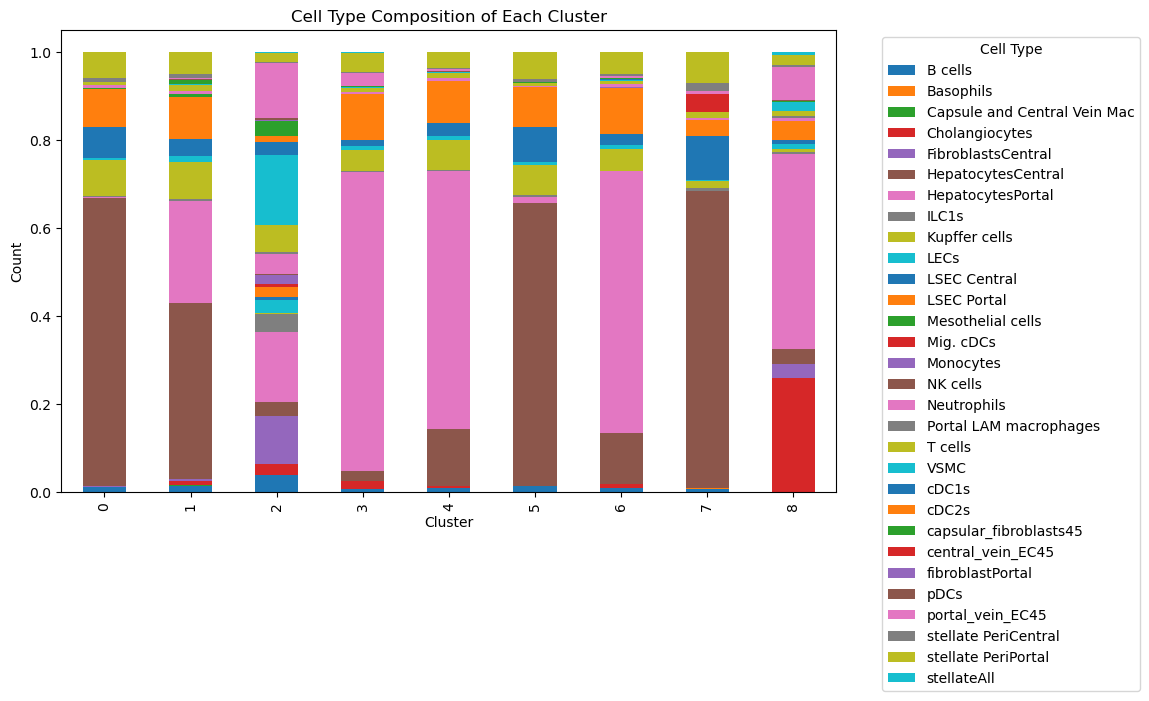

In [17]:
# Group the dataframe by cluster and cell type, and count the occurrences
grouped_df = st_data.obs.groupby(['leiden_covet', 'annotationSave']).size().unstack()

# Normalize the counts to get the proportion of each cell type in each cluster
grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)

# Filter to only clusters with more than 1000 cells
# grouped_df = grouped_df.loc[st_data.obs['leiden_covet'].value_counts() > 1000, ]

# Plot the stacked barplot
grouped_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set the labels and title
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cell Type Composition of Each Cluster')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1))

In [25]:
# For each cluster, print out the top 5 highest proportion cell types along with their proportions
for cluster in range(15):
    print(f"Cluster {cluster}")
    cluster_data = st_data[st_data.obs.leiden_covet == str(cluster)]
    cluster_data.obs.annotationSave.value_counts(normalize=True).head(5)
    print(cluster_data.obs.annotationSave.value_counts(normalize=True).head(5))
    print("\n")

Cluster 0
annotationSave
HepatocytesCentral     0.654172
LSEC Portal            0.086457
Kupffer cells          0.081620
LSEC Central           0.070738
stellate PeriPortal    0.058041
Name: proportion, dtype: float64


Cluster 1
annotationSave
HepatocytesCentral     0.400676
HepatocytesPortal      0.232432
LSEC Portal            0.094595
Kupffer cells          0.085135
stellate PeriPortal    0.050676
Name: proportion, dtype: float64


Cluster 2
annotationSave
HepatocytesPortal     0.158949
VSMC                  0.158949
portal_vein_EC45      0.125156
FibroblastsCentral    0.108886
T cells               0.062578
Name: proportion, dtype: float64


Cluster 3
annotationSave
HepatocytesPortal      0.679878
LSEC Portal            0.104421
Kupffer cells          0.047256
stellate PeriPortal    0.043445
portal_vein_EC45       0.029726
Name: proportion, dtype: float64


Cluster 4
annotationSave
HepatocytesPortal      0.586636
HepatocytesCentral     0.129105
LSEC Portal            0.096263
Kupf

## KC subset

In [18]:
# Cluster on only KCs
kcs = st_data[st_data.obs['annotationSave'] == 'Kupffer cells', :]

In [19]:
kcs

View of AnnData object with n_obs × n_vars = 613 × 99
    obs: 'region', 'instance', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_2_genes', 'pct_counts_in_top_5_genes', 'n_counts', 'shapeSize', 'leiden', 'portal_vein_EC45', 'LSEC45', 'LSEC Portal', 'LSEC Central', 'central_vein_EC45', 'stellateAll', 'stellate PeriPortal', 'stellate PeriCentral', 'FibroblastAll', 'fibroblastPortal', 'FibroblastsCentral', 'VSMC', 'capsular_fibroblasts45', 'Mesothelial cells', 'Hepatocytes', 'HepatocytesPortal', 'HepatocytesCentral', 'Cholangiocytes', 'cDC2s', 'Mig. cDCs', 'Neutrophils', 'Basophils', 'NK cells', 'ILC1s', 'T cells', 'pDCs', 'B cells', 'cDC1s', 'Kupffer cells', 'Capsule and Central Vein Mac', 'Portal LAM macrophages', 'Monocytes', 'LECs', 'Cleanliness', 'annotation', 'Hep', 'annotationSave', 'Other immunecells', 'score_celltype_own_score_genes', 'second_score_celltype_own_score_genes', 'cleanliness_own_score_genes', 'annotation_own

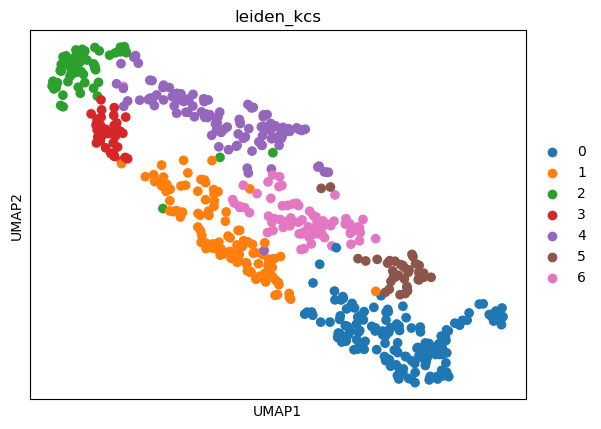

In [20]:
sc.pp.neighbors(kcs, use_rep='covet_sqrt_flat', n_neighbors=20)
sc.tl.umap(kcs, min_dist=0)
sc.tl.leiden(
    kcs,
    resolution=0.75,
    flavor="igraph",
    key_added='leiden_kcs'
)

sc.pl.umap(kcs, color=['leiden_kcs'])

In [22]:
# Match the leiden clusters to the original data, NA if not KC
st_data.obs['leiden_covet_kcs'] = np.nan
st_data.obs['leiden_covet_kcs'][st_data.obs['annotationSave'] == 'Kupffer cells'] = kcs.obs['leiden_kcs'].values

/tmp/ipykernel_11544/3704898222.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  st_data.obs['leiden_covet_kcs'][st_data.obs['annotationSave'] == 'Kupffer cells'] = kcs.obs['leiden_kcs'].values
/tmp/ipykernel_11544/3704898222.py:3: Settin

<Axes: title={'center': 'leiden_covet_kcs'}, xlabel='spatial1', ylabel='spatial2'>

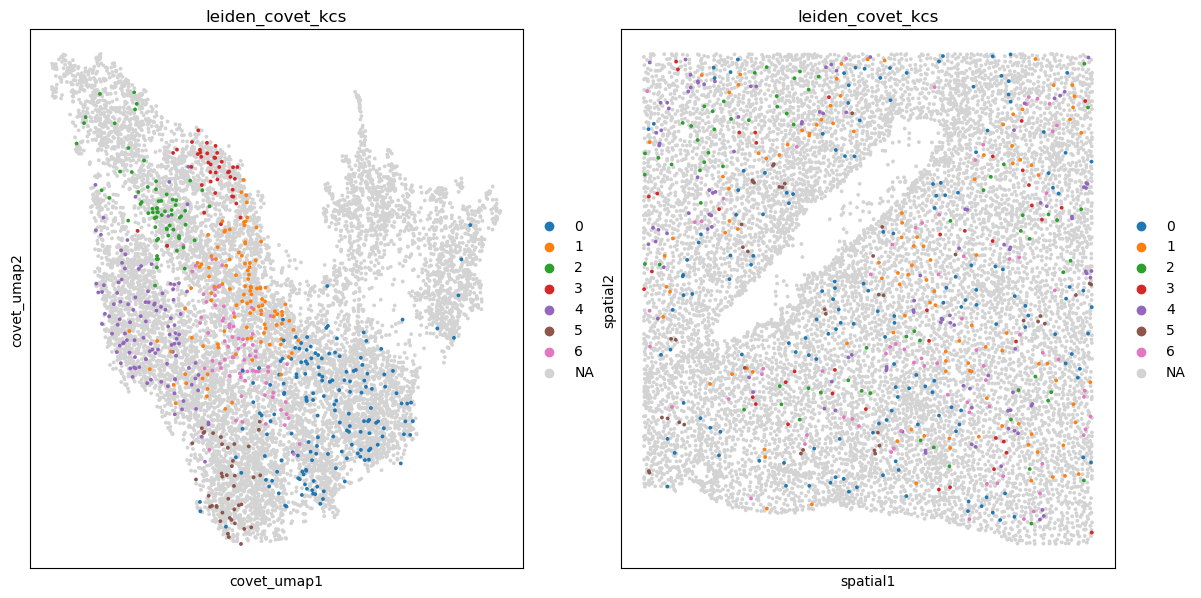

In [24]:
# Create 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

sc.pl.embedding(st_data, basis='covet_umap', color='leiden_covet_kcs', size=30, ax=ax[0], show=False)
sc.pl.embedding(st_data, basis='spatial', color='leiden_covet_kcs', size=30,  ax=ax[1], show=False)
